<a href="https://colab.research.google.com/github/asgardian1196/asg-ml/blob/main/SimGAN_for_Captcha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SimGAN-Captcha

The aim of my project is to develop a system that will use SimGAN (A method developed by researchers at Apple, for refining synthetic images to make them look more realistic)  on a captcha image dataset and correctly predict captchas, without having to label them manually during the model training phase.

It involves using a simulated unsupervised learning approach, that contains a captcha synthesizer and a refiner trained with GAN. This will generate synthesized training pairs for classifying captchas. 

Its underlying model is SimGAN developed by Apple ([pdf](https://arxiv.org/pdf/1612.07828v1.pdf)


## Preprocessing

### Download target captcha files

Here we download some captchas from the contest website. Each batch has 1000 captchas. We'll use 20000 so 20 batches.

In [ ]:
"""
python                    3.7
tensorflow                1.14.0
keras                     2.1.5

NOTE:
Code is run locally, to address version conflicts between python and tensorflow/keras
"""

In [ ]:
import requests
import threading
URL = "https://captcha.delorean.codes/u/rickyhan/challenge"
DIR = "challenges/"
NUM_CHALLENGES = 20
lock = threading.Lock()

The data was in the form of compressed base64 encoded files. Here we will decode and decompress the captcha data.

We have around 20,000 captcha images to train our model

In [ ]:
import json, base64, os

IMG_DIR = "/PycharmProjects/SimGAN_exps/SimGAN-Captcha/captchas"
CHALLENGE_DIR = '/PycharmProjects/SimGAN_exps/SimGAN-Captcha/challenges'
fnames = ["{}/challenge-{}".format(CHALLENGE_DIR, i) for i in range(NUM_CHALLENGES)]
if not os.path.exists(IMG_DIR):
    os.mkdir(IMG_DIR)

"""
def save_imgs(fname):
    with open(fname) as f:
        l = json.loads(f.read())

    for image in l['images']:
        b = base64.b64decode(image['jpg_base64'])
        name = image['name']
        with open(IMG_DIR+"/{}.jpg".format(name), 'wb') as f:
            f.write(b)

for fname in fnames:
    save_imgs(fname)
assert len(os.listdir(IMG_DIR)) == 1000 * NUM_CHALLENGES
"""

'\ndef save_imgs(fname):\n    with open(fname) as f:\n        l = json.loads(f.read())\n\n    for image in l[\'images\']:\n        b = base64.b64decode(image[\'jpg_base64\'])\n        name = image[\'name\']\n        with open(IMG_DIR+"/{}.jpg".format(name), \'wb\') as f:\n            f.write(b)\n\nfor fname in fnames:\n    save_imgs(fname)\nassert len(os.listdir(IMG_DIR)) == 1000 * NUM_CHALLENGES\n'

### Decompression

Each challenge file is actually a json object containing 1000 base64 encoded jpg image file. So for each of these challenge files, we decompress each base64 strs into a jpeg and put that under a separate folder.

In [ ]:
from PIL import Image
IMG_DIR = "/PycharmProjects/SimGAN_exps/SimGAN-Captcha/captchas"
imgpath = IMG_DIR + "/"+ os.listdir(IMG_DIR)[0]
imgpath2 = IMG_DIR + "/"+ os.listdir(IMG_DIR)[3]
im = Image.open(IMG_DIR + "/000425062e2850b10efe900466f85cc8.jpg")
im2 = Image.open(IMG_DIR + "/00096056feba457e424771981e390d9b.jpg")
IMG_FNAMES = [IMG_DIR + '/' + p for p in os.listdir(IMG_DIR)]

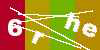

In [ ]:
im

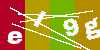

In [ ]:
im2

### Convert to black and white
Instead of RGB, binarized image saves significant compute. Here we hardcode a threshold and iterate over each pixel to obtain a binary image.

In [ ]:
def gray(img_path):
    # convert to grayscale, then binarize
    img = Image.open(img_path).convert("L")
    img = img.point(lambda x: 255 if x > 200 or x == 0 else x) # value found through T&E
    img = img.point(lambda x: 0 if x < 255 else 255, "1")
    img.save(img_path)

for img_path in IMG_FNAMES:
    gray(img_path)

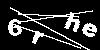

In [ ]:
im = Image.open(IMG_DIR + "/000425062e2850b10efe900466f85cc8.jpg")
im

### Find mask

As you may have noticed, all the captchas share the same horizontal lines. Si
We will extract and save the lines(noise) for later use. Here we average all 20000 captchas and set a threshold as above. Another method is using a bit mask (&=) to iteratively filter out surrounding black pixels i.e.

```
mask = np.ones((height, width))
for im in ims:
    mask &= im
```

The effectiveness of bit mask depends on how clean the binarized data is. With the averaging method, some error is allowed.

In [ ]:
import numpy as np
WIDTH, HEIGHT = im.size
MASK_DIR = "avg.png"

In [ ]:
WIDTH, HEIGHT

(100, 50)

In [ ]:
def generateMask():
    N=1000*NUM_CHALLENGES
    arr=np.zeros((HEIGHT, WIDTH),np.float)
    for fname in IMG_FNAMES:
        imarr=np.array(Image.open(fname),dtype=np.float)
        arr=arr+imarr/N
    arr=np.array(np.round(arr),dtype=np.uint8)
    out=Image.fromarray(arr,mode="L")
    out.save(MASK_DIR)

generateMask()

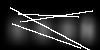

In [ ]:
im = Image.open(MASK_DIR) # ok this can be done with binary mask: &=
im

In [ ]:
im = Image.open(MASK_DIR)
im = im.point(lambda x:255 if x > 230 else x)
im = im.point(lambda x:0 if x<255 else 255, "1")
im.save(MASK_DIR)

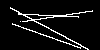

In [ ]:
im

In [ ]:
im.size

# Generator for real captchas

Using a Keras built in generator function `flow_from_directory` to automatically import and preprocess real captchas from a folder.

In [ ]:
from keras import models
from keras import layers
from keras import optimizers
from keras import applications
from keras.preprocessing import image
import tensorflow as tf

Using TensorFlow backend.


In [ ]:
# Real data generator
BATCH_SIZE = 32 

datagen = image.ImageDataGenerator(
    preprocessing_function=applications.xception.preprocess_input
)

flow_from_directory_params = {'target_size': (HEIGHT, WIDTH),
                              'color_mode': 'grayscale',
                              'class_mode': None,
                              'batch_size': BATCH_SIZE}

real_generator = datagen.flow_from_directory(
        directory=".",
        **flow_from_directory_params
)

Found 20011 images belonging to 8 classes.


# (Regular) Generator

Now that we have processed all the real captchas, we need to define a generator that outputs (captcha, label) pairs where the captchas should look almost like the real ones.

We filter out the outliers that contain overlapping characters.

In [ ]:
# Synthetic captcha generator
from PIL import ImageFont, ImageDraw
from random import choice, random
from string import ascii_lowercase, digits
alphanumeric = ascii_lowercase + digits


def fuzzy_loc(locs):
    acc = []
    for i,loc in enumerate(locs[:-1]):
        if locs[i+1] - loc < 8:
            continue
        else:
            acc.append(loc)
    return acc

def seg(img):
    arr = np.array(img, dtype=np.float)
    arr = arr.transpose()
    # arr = np.mean(arr, axis=2)
    arr = np.sum(arr, axis=1)
    locs = np.where(arr < arr.min() + 2)[0].tolist()
    locs = fuzzy_loc(locs)
    return locs

def is_well_formed(img_path):
    original_img = Image.open(img_path)
    img = original_img.convert('1')
    return len(seg(img)) == 4

noiseimg = np.array(Image.open("avg.png").convert("1"))
# noiseimg = np.bitwise_not(noiseimg)
fnt = ImageFont.truetype('./arial-extra.otf', 26)
def gen_one():
    og = Image.new("1", (100,50))
    text = ''.join([choice(alphanumeric) for _ in range(4)])
    draw = ImageDraw.Draw(og)
    for i, t in enumerate(text):
        txt=Image.new('L', (40,40))
        d = ImageDraw.Draw(txt)
        d.text( (0, 0), t,  font=fnt, fill=255)
        if random() > 0.5:
            w=txt.rotate(-20*(random()-1),  expand=1)
            og.paste( w, (i*20 + int(25*random()), int(25+30*(random()-1))),  w)
        else:
            w=txt.rotate(20*(random()-1),  expand=1)
            og.paste( w, (i*20 + int(25*random()), int(20*random())),  w)
    segments = seg(og)
    if len(segments) != 4:
        return gen_one()
    ogarr = np.array(og)
    ogarr = np.bitwise_or(noiseimg, ogarr)
    ogarr = np.expand_dims(ogarr, axis=2).astype(float)
    ogarr = np.random.random(size=(50,100,1)) * ogarr
    ogarr = (ogarr > 0.0).astype(float) # add noise
    return ogarr, text

def synth_generator():
    arrs = []
    while True:
        for _ in range(BATCH_SIZE):
            arrs.append(gen_one()[0])
        yield np.array(arrs)
        arrs = []

In [ ]:
def get_image_batch(generator):
    """keras generators may generate an incomplete batch for the last batch"""
    #img_batch = generator.next() 
    img_batch = next(generator) 
    if len(img_batch) != BATCH_SIZE:
        #img_batch = generator.next() 
        img_batch = next(generator)

    assert len(img_batch) == BATCH_SIZE

    return img_batch

In [ ]:
import matplotlib.pyplot as plt
imarr = get_image_batch(real_generator)[0, :, :, 0]
plt.imshow(imarr)

(50, 100)


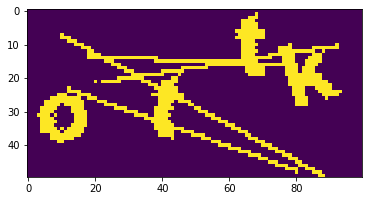

In [ ]:
imarr = get_image_batch(synth_generator())[0, :, :, 0]
print(imarr.shape)
plt.imshow(imarr)

# SimGAN Definition

There are three components to the network:

### Refiner

The refiner network, Rθ, is a residual network (ResNet). It modifies the synthetic image on a pixel level, rather than holistically modifying the image content, preserving the global structure and annotations.

### Discriminator

The discriminator network Dφ, is a simple ConvNet that contains 5 conv layers and 2 max-pooling layers. It's abinary classifier that outputs whether a captcha is synthesized or real.

### Combined

Pipe the refined image into discriminator.


![SimGAN](http://www.fudzilla.com/images/stories/2016/December/apple-simgan-generative-adversarial-networks.jpg)

In [ ]:
def refiner_network(input_image_tensor):
    """
    :param input_image_tensor: Input tensor that corresponds to a synthetic image.
    :return: Output tensor that corresponds to a refined synthetic image.
    """
    def resnet_block(input_features, nb_features=64, nb_kernel_rows=3, nb_kernel_cols=3):
        """
        A ResNet block with two `nb_kernel_rows` x `nb_kernel_cols` convolutional layers,
        each with `nb_features` feature maps.
        See Figure 6 in https://arxiv.org/pdf/1612.07828v1.pdf.
        :param input_features: Input tensor to ResNet block.
        :return: Output tensor from ResNet block.
        """
        y = layers.Convolution2D(nb_features, nb_kernel_rows, nb_kernel_cols, border_mode='same')(input_features)
        y = layers.Activation('relu')(y)
        y = layers.Convolution2D(nb_features, nb_kernel_rows, nb_kernel_cols, border_mode='same')(y)

        #y = layers.merge([input_features, y], mode='sum') 
        y = layers.add([input_features, y])
        return layers.Activation('relu')(y)

    # an input image of size w × h is convolved with 3 × 3 filters that output 64 feature maps
    x = layers.Convolution2D(64, 3, 3, border_mode='same', activation='relu')(input_image_tensor)

    # the output is passed through 4 ResNet blocks
    for _ in range(4):
        x = resnet_block(x)

    # the output of the last ResNet block is passed to a 1 × 1 convolutional layer producing 1 feature map
    # corresponding to the refined synthetic image
    return layers.Convolution2D(1, 1, 1, border_mode='same', activation='tanh')(x)

def discriminator_network(input_image_tensor):
    """
    :param input_image_tensor: Input tensor corresponding to an image, either real or refined.
    :return: Output tensor that corresponds to the probability of whether an image is real or refined.
    """
    x = layers.Convolution2D(96, 3, 3, border_mode='same', subsample=(2, 2), activation='relu')(input_image_tensor)
    x = layers.Convolution2D(64, 3, 3, border_mode='same', subsample=(2, 2), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), border_mode='same', strides=(1, 1))(x)
    x = layers.Convolution2D(32, 3, 3, border_mode='same', subsample=(1, 1), activation='relu')(x)
    x = layers.Convolution2D(32, 1, 1, border_mode='same', subsample=(1, 1), activation='relu')(x)
    x = layers.Convolution2D(2, 1, 1, border_mode='same', subsample=(1, 1), activation='relu')(x)

    # here one feature map corresponds to `is_real` and the other to `is_refined`,
    # and the custom loss function is then `tf.nn.sparse_softmax_cross_entropy_with_logits`
    return layers.Reshape((-1, 2))(x)

# Refiner
synthetic_image_tensor = layers.Input(shape=(HEIGHT, WIDTH, 1))
refined_image_tensor = refiner_network(synthetic_image_tensor)
refiner_model = models.Model(input=synthetic_image_tensor, output=refined_image_tensor, name='refiner')

# Discriminator
refined_or_real_image_tensor = layers.Input(shape=(HEIGHT, WIDTH, 1))
discriminator_output = discriminator_network(refined_or_real_image_tensor)
discriminator_model = models.Model(input=refined_or_real_image_tensor, output=discriminator_output,
                                   name='discriminator')

# Combined
refiner_model_output = refiner_model(synthetic_image_tensor)
combined_output = discriminator_model(refiner_model_output)
combined_model = models.Model(input=synthetic_image_tensor, output=[refiner_model_output, combined_output],
                              name='combined')

def self_regularization_loss(y_true, y_pred):
    delta = 0.0001  # FIXME: need to figure out an appropriate value for this
    return tf.multiply(delta, tf.reduce_sum(tf.abs(y_pred - y_true)))

# define custom local adversarial loss (softmax for each image section) for the discriminator
# the adversarial loss function is the sum of the cross-entropy losses over the local patches
def local_adversarial_loss(y_true, y_pred):
    # y_true and y_pred have shape (batch_size, # of local patches, 2), but really we just want to average over
    # the local patches and batch size so we can reshape to (batch_size * # of local patches, 2)
    y_true = tf.reshape(y_true, (-1, 2))
    y_pred = tf.reshape(y_pred, (-1, 2))
    loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)

    return tf.reduce_mean(loss)


# compile models
sgd = optimizers.RMSprop()

refiner_model.compile(optimizer=sgd, loss=self_regularization_loss)
discriminator_model.trainable = False
discriminator_model.compile(optimizer=sgd, loss=local_adversarial_loss)
#discriminator_model.trainable = False  
combined_model.compile(optimizer=sgd, loss=[self_regularization_loss, local_adversarial_loss])

W0517 05:56:45.413450 4431386112 deprecation_wrapper.py:119] From /Users/ashah04/anaconda3/envs/VE_python3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0517 05:56:45.440573 4431386112 deprecation_wrapper.py:119] From /Users/ashah04/anaconda3/envs/VE_python3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/Users/ashah04/anaconda3/envs/VE_python3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
W0517 05:56:45.445131 4431386112 deprecation_wrapper.py:119] From /Users/ashah04/anaconda3/envs/VE_python3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.


# Pre-training

It is not necessary to pre-train GANs but it seems pretraining makes GANs converge faster. Here we pre-train both models. For the refiner, we train by supplying the identity. For the discriminator, we train with the correct real, synth labeled pairs.

In [ ]:
# the target labels for the cross-entropy loss layer are 0 for every yj (real) and 1 for every xi (refined)

y_real = np.array([[[1.0, 0.0]] * discriminator_model.output_shape[1]] * BATCH_SIZE)
y_refined = np.array([[[0.0, 1.0]] * discriminator_model.output_shape[1]] * BATCH_SIZE)
assert y_real.shape == (BATCH_SIZE, discriminator_model.output_shape[1], 2)

In [ ]:
"""
LOG_INTERVAL = 10
MODEL_DIR = "./model/"
print('pre-training the refiner network...')
gen_loss = np.zeros(shape=len(refiner_model.metrics_names))

for i in range(100):
    synthetic_image_batch = get_image_batch(synth_generator())
    gen_loss = np.add(refiner_model.train_on_batch(synthetic_image_batch, synthetic_image_batch), gen_loss)

    # log every `log_interval` steps
    if not i % LOG_INTERVAL:
        print('Refiner model self regularization loss: {}.'.format(gen_loss / LOG_INTERVAL))
        gen_loss = np.zeros(shape=len(refiner_model.metrics_names))

refiner_model.save(os.path.join(MODEL_DIR, 'refiner_model_pre_trained.h5'))
"""


pre-training the refiner network...


W0517 02:41:31.784706 4757124608 deprecation_wrapper.py:119] From /Users/ashah04/anaconda3/envs/VE_python3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0517 02:41:31.789491 4757124608 deprecation_wrapper.py:119] From /Users/ashah04/anaconda3/envs/VE_python3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Refiner model self regularization loss: [4.18577271].
Refiner model self regularization loss: [38.10543156].
Refiner model self regularization loss: [9.86646509].
Refiner model self regularization loss: [5.06063788].
Refiner model self regularization loss: [2.25852749].
Refiner model self regularization loss: [1.26912575].
Refiner model self regularization loss: [4.72551188].
Refiner model self regularization loss: [0.35142342].
Refiner model self regularization loss: [0.1755028].
Refiner model self regularization loss: [0.13331901].


In [ ]:
from keras.models import load_model
refiner_model = load_model('/PycharmProjects/SimGAN_exps/\
SimGAN-Captcha/model/refiner_model_pre_trained.h5', \
                             custom_objects={'self_regularization_loss': self_regularization_loss})

In [ ]:
refiner_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 50, 100, 1)   0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 50, 100, 64)  640         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 50, 100, 64)  36928       conv2d_10[0][0]                  
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 50, 100, 64)  0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 

In [ ]:
"""
from tqdm import tqdm
print('pre-training the discriminator network...')
disc_loss = np.zeros(shape=len(discriminator_model.metrics_names))
MODEL_DIR = "./model/"
for _ in tqdm(range(100)):
    real_image_batch = get_image_batch(real_generator)
    disc_loss = np.add(discriminator_model.train_on_batch(real_image_batch, y_real), disc_loss)

    synthetic_image_batch = get_image_batch(synth_generator())
    refined_image_batch = refiner_model.predict_on_batch(synthetic_image_batch)
    disc_loss = np.add(discriminator_model.train_on_batch(refined_image_batch, y_refined), disc_loss)

discriminator_model.save(os.path.join(MODEL_DIR, 'discriminator_model_pre_trained.h5'))

# hard-coded for now
print('Discriminator model loss: {}.'.format(disc_loss / (100 * 2)))
"""

  0%|          | 0/100 [00:00<?, ?it/s]

pre-training the discriminator network...


100%|██████████| 100/100 [01:44<00:00,  1.06s/it]

Discriminator model loss: [0.6964737].


In [ ]:
from keras.models import load_model
discriminator_model = load_model('/PycharmProjects/SimGAN_exps/\
SimGAN-Captcha/model/discriminator_model_pre_trained.h5', \
                             custom_objects={'local_adversarial_loss': local_adversarial_loss})

In [ ]:
discriminator_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50, 100, 1)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 25, 50, 96)        960       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 13, 25, 64)        55360     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 25, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 13, 25, 32)        18464     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 25, 32)        1056      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 25, 2)         66        
__________

# Training

This is the most important training step in which we refine a synthesized captcha, then pass it through the discriminator and backprop gradients.

In [ ]:
from image_history_buffer import ImageHistoryBuffer

k_d = 1  # number of discriminator updates per step
k_g = 2  # number of generative network updates per step
nb_steps = 100 # original 1000

###############
HEIGHT = 50
WIDTH = 100
BATCH_SIZE = 32
import numpy as np
LOG_INTERVAL = 10
MODEL_DIR = "./model_temp/"
#############


# TODO: what is an appropriate size for the image history buffer?
image_history_buffer = ImageHistoryBuffer((0, HEIGHT, WIDTH, 1), BATCH_SIZE * 100, BATCH_SIZE)

combined_loss = np.zeros(shape=len(combined_model.metrics_names))
disc_loss_real = np.zeros(shape=len(discriminator_model.metrics_names))
disc_loss_refined = np.zeros(shape=len(discriminator_model.metrics_names))

# see Algorithm 1 in https://arxiv.org/pdf/1612.07828v1.pdf
for i in range(nb_steps):
    print('Step: {} of {}.'.format(i, nb_steps))

    # train the refiner
    for _ in range(k_g * 2):
        # sample a mini-batch of synthetic images
        synthetic_image_batch = get_image_batch(synth_generator())

        # update θ by taking an SGD step on mini-batch loss LR(θ)
        combined_loss = np.add(combined_model.train_on_batch(synthetic_image_batch,
                                                             [synthetic_image_batch, y_real]), combined_loss)

    for _ in range(k_d):
        # sample a mini-batch of synthetic and real images
        synthetic_image_batch = get_image_batch(synth_generator())
        real_image_batch = get_image_batch(real_generator)

        # refine the synthetic images w/ the current refiner
        refined_image_batch = refiner_model.predict_on_batch(synthetic_image_batch)

        # use a history of refined images
        half_batch_from_image_history = image_history_buffer.get_from_image_history_buffer()
        image_history_buffer.add_to_image_history_buffer(refined_image_batch)

        if len(half_batch_from_image_history):
            refined_image_batch[:batch_size // 2] = half_batch_from_image_history

        # update φ by taking an SGD step on mini-batch loss LD(φ)
        disc_loss_real = np.add(discriminator_model.train_on_batch(real_image_batch, y_real), disc_loss_real)
        disc_loss_refined = np.add(discriminator_model.train_on_batch(refined_image_batch, y_refined),
                                   disc_loss_refined)

    if not i % LOG_INTERVAL:
        # log loss summary
        print('Refiner model loss: {}.'.format(combined_loss / (LOG_INTERVAL * k_g * 2)))
        print('Discriminator model loss real: {}.'.format(disc_loss_real / (LOG_INTERVAL * k_d * 2)))
        print('Discriminator model loss refined: {}.'.format(disc_loss_refined / (LOG_INTERVAL * k_d * 2)))

        combined_loss = np.zeros(shape=len(combined_model.metrics_names))
        disc_loss_real = np.zeros(shape=len(discriminator_model.metrics_names))
        disc_loss_refined = np.zeros(shape=len(discriminator_model.metrics_names))

        # save model checkpoints
        model_checkpoint_base_name = os.path.join(MODEL_DIR, '{}_model_step_{}.h5')
        refiner_model.save(model_checkpoint_base_name.format('refiner', i))
        discriminator_model.save(model_checkpoint_base_name.format('discriminator', i))


Step: 0 of 100.
Refiner model loss: [0.07789041 0.00836448 0.06952593].
Discriminator model loss real: [0.00081097].
Discriminator model loss refined: [0.03466143].
Step: 1 of 100.
Step: 2 of 100.
Step: 3 of 100.
Step: 4 of 100.
Step: 5 of 100.
Step: 6 of 100.
Step: 7 of 100.
Step: 8 of 100.
Step: 9 of 100.
Step: 10 of 100.
Refiner model loss: [0.7773678  0.08213493 0.69523288].
Discriminator model loss real: [0.00185382].
Discriminator model loss refined: [0.34658189].
Step: 11 of 100.
Step: 12 of 100.
Step: 13 of 100.
Step: 14 of 100.
Step: 15 of 100.
Step: 16 of 100.
Step: 17 of 100.
Step: 18 of 100.
Step: 19 of 100.
Step: 20 of 100.
Refiner model loss: [0.70367267 0.00841001 0.69526266].
Discriminator model loss real: [0.00022714].
Discriminator model loss refined: [0.34657419].
Step: 21 of 100.
Step: 22 of 100.
Step: 23 of 100.
Step: 24 of 100.
Step: 25 of 100.
Step: 26 of 100.
Step: 27 of 100.
Step: 28 of 100.
Step: 29 of 100.
Step: 30 of 100.
Refiner model loss: [0.79859564 0.10

In [ ]:

from keras.models import load_model
refiner_model = load_model('/PycharmProjects/SimGAN_exps/\
SimGAN-Captcha/model_temp/refiner_model_step_70.h5', \
                             custom_objects={'self_regularization_loss': self_regularization_loss})

discriminator_model = load_model('/PycharmProjects/SimGAN_exps/\
SimGAN-Captcha/model_temp/discriminator_model_step_70.h5', \
                             custom_objects={'local_adversarial_loss': local_adversarial_loss})

W0517 05:56:55.932656 4431386112 deprecation_wrapper.py:119] From /Users/ashah04/anaconda3/envs/VE_python3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0517 05:56:55.933335 4431386112 deprecation_wrapper.py:119] From /Users/ashah04/anaconda3/envs/VE_python3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



# Results of SimGAN:

As you can see below, we no longer have the cookie-cutter fonts. There are quite a few artifacts that did not exist before refinement. The edges are blurred and noisy - which is *impossible* to simulate heuristically. And it is exactly these tiny things that renders MNIST-like convnet useless.

Now the refined results are basically the original captchas.

In [ ]:
synthetic_image_batch = get_image_batch(synth_generator())
arr = refiner_model.predict_on_batch(synthetic_image_batch)

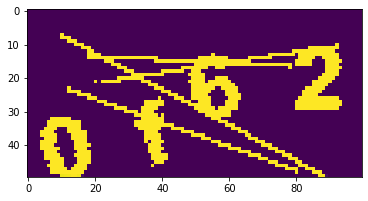

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(arr[20, :, :, 0])

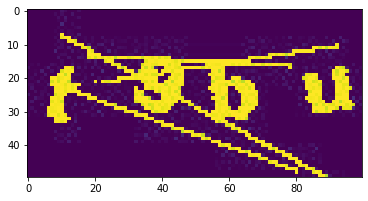

In [ ]:
plt.imshow(get_image_batch(real_generator)[2,:,:,0])

# MNIST for Captcha

Now we finish the puzzle by building an MNIST like convnet to predict captcha labels.

In [ ]:
n_class = len(alphanumeric)

def mnist_raw_generator(batch_size=128):
    X = np.zeros((batch_size, HEIGHT, WIDTH, 1), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for _ in range(4)] # 4 chars
    while True:
        for i in range(batch_size):
            im, random_str = gen_one()
            X[i] = im
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, alphanumeric.find(ch)] = 1
        yield np.array(X), y

def mnist_generator(batch_size=128):
    X = np.zeros((batch_size, HEIGHT, WIDTH, 1), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for _ in range(4)] # 4 chars
    while True:
        for i in range(batch_size):
            im, random_str = gen_one()
            X[i] = im
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, alphanumeric.find(ch)] = 1
        yield refiner_model.predict(np.array(X)), y

#mg = mnist_generator().next()
mg = next(mnist_generator())

# plt.imshow(mg[0][0,:,:,0]) # sanity check

In [ ]:
from keras.layers import *

input_tensor = Input((HEIGHT, WIDTH, 1))
x = input_tensor
x = Conv2D(32, kernel_size=(3, 3),
                 activation='relu')(x)
for _ in range(4):
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]

model = models.Model(inputs=input_tensor, outputs=x)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

W0517 06:00:43.644506 4431386112 deprecation.py:506] From /Users/ashah04/anaconda3/envs/VE_python3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
from keras.callbacks import History
history = History()
model.fit_generator(mnist_generator(), steps_per_epoch=1000, epochs=20, callbacks=[history])  # 1000 --> 5

W0517 06:01:17.340676 4431386112 deprecation.py:323] From /Users/ashah04/anaconda3/envs/VE_python3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20


# Let's test the trained model

## Synthetic

(-0.5, 99.5, 49.5, -0.5)

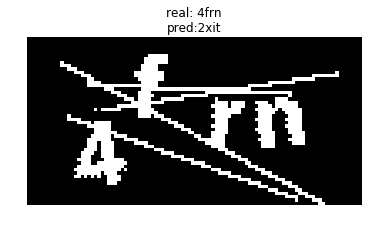

In [ ]:
def decode(y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([alphanumeric[x] for x in y])

X, y = next(mnist_generator(1))
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0, :, :, 0], cmap='gray')
plt.axis('off')

## Real

(-0.5, 99.5, 49.5, -0.5)

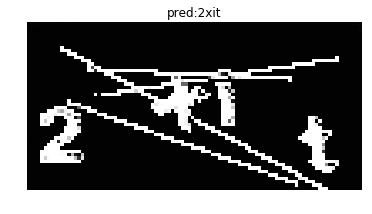

In [ ]:

X = next(real_generator)
X = refiner_model.predict(X)
y_pred = model.predict(X)
plt.title('pred:%s'%(decode(y_pred)))
plt.imshow(X[0,:,:,0], cmap='gray')
plt.axis('off')